In [6]:
import numpy as numpy
from matplotlib import pyplot as matplot
%matplotlib inline
import pandas as pandas
import math
from sklearn import preprocessing
from sklearn import svm
import cv2
import os
import ntpath
from sklearn.metrics.pairwise import cosine_similarity
import fnmatch
import math
from math import sqrt,log
from cmath import sqrt

data = []
Filename = []
Person = []
angles = []
Len = []
Rho = []


def crop_image(img,tol=0):
    mask = img>tol
    return img[numpy.ix_(mask.any(1),mask.any(0))]
def thinning(img):
    #img = cropimage
    size = numpy.size(img)
    skel = numpy.zeros(img.shape,numpy.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True

  #  plt.imshow(skel,'gray')
   # plt.show()
    return skel
def coords(thinnedimage):
    rows,cols=thinnedimage.shape
    img_topleft=thinnedimage[0:int(rows/2),0:int(cols/2)]
    img_topright=thinnedimage[int(rows/2)+1:rows,0:int(cols/2)]
    img_bottomleft=thinnedimage[0:int(rows/2),int(cols/2)+1:cols]
    img_bottomright=thinnedimage[int(rows/2)+1:rows,int(cols/2)+1:cols]
    
    topleft_x,topleft_y=COG(img_topleft)
    topright_x,topright_y=COG(img_topright)
    bottomleft_x,bottomleft_y=COG(img_bottomleft)
    bottomright_x,bottomright_y=COG(img_bottomright)

    return topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y

def COG(img):
    x_cor=0
    xrun_sum=0
    y_cor=0
    yrun_sum=0
    #print(img.shape)
    for i in range(img.shape[0]):
        x_cor+=sum(img[i])*i/255
        xrun_sum+=sum(img[i])/255

    for i in range(img.shape[1]):
        y_cor+=sum(img[:,i])*i/255
        yrun_sum+=sum(img[:,i])/255
        #print(img.shape[1]) 
        if yrun_sum==0:
            x_pos=0
        else:
            x_pos=y_cor/(yrun_sum)
        if xrun_sum==0:
            y_pos=0
        else:
            y_pos=x_cor/(xrun_sum)
        
   # print(x_pos)
  #  print(y_pos)
    
    return (x_pos/img.shape[1],y_pos/img.shape[0])

def tan_i(x):
    #print(x)
    if x[0]==0:
        return 90
    return math.degrees(math.atan(x[1]/x[0]))

def tan(thinnedimage):
    rows,cols=thinnedimage.shape
    
    img_tl1=thinnedimage[0:int(rows/2),0:int(cols/4)]
    img_tl2=thinnedimage[0:int(rows/2),int(cols/4)+1:int(cols/2)]
    
    img_tr1=thinnedimage[0:int(rows/2),int(cols/2)+1:int(0.75*cols)]
    img_tr2=thinnedimage[0:int(rows/2),int(0.75*cols)+1:cols]
    
    img_bl1=thinnedimage[int(rows/2)+1:rows,0:int(cols/4)]
    img_bl2=thinnedimage[int(rows/2)+1:rows,int(cols/4)+1:int(cols/2)]
    
    img_br1=thinnedimage[int(rows/2)+1:rows,int(cols/2)+1:int(0.75*cols)]
    img_br2=thinnedimage[int(rows/2)+1:rows,int(0.75*cols)+1:cols]
    

    #plt.imshow(timg,'gray')
    #plt.show()
    
    tl1=tan_i(COG(img_tl1))
    tl2=tan_i(COG(img_tl2))
    tr1=tan_i(COG(img_tr1))
    tr2=tan_i(COG(img_tr2))
    bl1=tan_i(COG(img_bl1))
    bl2=tan_i(COG(img_bl2))
    br1=tan_i(COG(img_br1))
    br2=tan_i(COG(img_br2))
    
    #plt.imshow(img_br1,'gray')
    #plt.show()
    #print(COG(img_br1))
    return tl1,tl2,tr1,tr2,bl1,bl2,br1,br2

def leng_rho(img):
    kernel = numpy.ones((2,2), numpy.uint8)
    img_dilation = cv2.dilate(img, kernel, iterations=2)
    img_erosion = cv2.erode(img, kernel, iterations=4)
    edges = cv2.Canny(img_erosion,cv2.THRESH_BINARY+cv2.THRESH_OTSU,550,apertureSize = 3)
    minLineLength=100
    maxLineGap=10
    threshold=20
    image=edges
    lines = cv2.HoughLinesP(image=img,rho=1,theta=numpy.pi/180, threshold=threshold,lines=numpy.array([]), minLineLength=minLineLength,maxLineGap=maxLineGap)
    for x1,y1,x2,y2 in lines[0]:
        theta = math.atan(float(y2 - y1) / (x2 - x1))
        Leng = sqrt((x2-x1)^2 + (y2-y1)^2)
        Rho = (x1 * y2 - x2 * y1) / Leng
        angles.append({'theta': theta, 'p1': (x1, y1), 'p2': (x2, y2)})
    #for i in range(len(angles)):
     #   for j in range(i + 1, len(angles)):
      #      delta = abs(angles[i]['theta'] - angles[j]['theta'])               
    a,b,c = lines.shape
    theta = round(theta,4)
    Rho = round(abs(Rho),0)
    Leng = round(abs(Leng),0)
    return a,b,c,theta,Rho,Leng

def createfingerprint_Genuine(image):
    aspect_ratio = 1.0*(image.shape[1]/image.shape[0])
    ret,thresh1 = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
    ret,thresh2 = cv2.threshold(image,127,255,cv2.THRESH_BINARY_INV)
    ret,thresh3 = cv2.threshold(image,127,255,cv2.THRESH_TRUNC)
    ret,thresh4 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO)
    ret,thresh5 = cv2.threshold(image,127,255,cv2.THRESH_TOZERO_INV)
    a,b,c,theta,Rho,Leng = leng_rho(image)
    blur = cv2.GaussianBlur(thresh1,(5,5),0)
    ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    image=numpy.invert(th3)
    
    cropimage=crop_image(image,tol=0)
    area=cv2.countNonZero(cropimage)
    area=cv2.countNonZero(cropimage)/(cropimage.shape[0]*cropimage.shape[1])

    img1=numpy.invert(cropimage)
    connectcomp=cv2.connectedComponents(img1)[0]

    thinnedimage=thinning(cropimage)
    
    topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y=coords(thinnedimage)
    tan_topleft_x, tan_topleft_y, tan_topright_x, tan_topright_y, tan_bottomleft_x, tan_bottomleft_y, tan_bottomright_x, tan_bottomright_y = tan(thinnedimage)
    
      
    a=pandas.Series([area,connectcomp,topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y,tan_topleft_x, tan_topleft_y, tan_topright_x, tan_topright_y, tan_bottomleft_x, tan_bottomleft_y, tan_bottomright_x, tan_bottomright_y,aspect_ratio, a,b,c,theta,Rho,Leng],index=
                    ["Norm_area","connected_comps","topleft_x","topleft_y","topright_x","topright_y","bottomleft_x","bottomleft_y","bottomright_x","bottomright_y","tan_topleft_x", "tan_topleft_y", "tan_topright_x", "tan_topright_y", "tan_bottomleft_x", "tan_bottomleft_y", "tan_bottomright_x", "tan_bottomright_y","Aspect_Ratio","a","b","c","theta","Rho","Leng"])
    data.append(a)

def create_training_Genuine_dataset(m):
    os.chdir(Genuinedir)
    filecount = len(fnmatch.filter(os.listdir(), '*.png'))
    n = int(filecount/m)
    for j in range(1,m+1):
        for i in range(1,n+1):
            path = f"C:\Siddhartha\\Confidential Documents\\Data Science\\Signature Verification\\Train_Genuine\\00{j}_{i}.png"
            fn = ntpath.basename(path)
            Filename.append(fn)
            tn = j
            Person.append(tn)
            image = cv2.imread(path,0)
            createfingerprint_Genuine(image)
            Original_Signature_Table=pandas.DataFrame(data)
            Original_Cosine = pandas.DataFrame(cosine_similarity(Original_Signature_Table), index = None)
    return Original_Signature_Table
    Original_Signature_Table['Filename'] = Filename
    Original_Cosine['Filename'] = Filename
    Trainingdatacol = Original_Signature_Table.columns.tolist()
    Trainingdatacol = Trainingdatacol[-1:]+Trainingdatacol[:-1]
    Original_Signature_Table = Original_Signature_Table[Trainingdatacol]
    Original_Signature_Table['Person'] = Person
    Trainingdatacol = Original_Signature_Table.columns.tolist()
    Trainingdatacol = Trainingdatacol[-1:]+Trainingdatacol[:-1]
    Original_Signature_Table = Original_Signature_Table[Trainingdatacol]
    Original_Signature_Table['Category'] = "Genuine"
    Cosinecolumns = Original_Cosine.columns.tolist()
    Cosinecolumns = Cosinecolumns[-1:]+Cosinecolumns[:-1]
    Original_Cosine = Original_Cosine[Cosinecolumns]
    #Original_Signature_Table = pandas.concat([Original_Signature_Table,Cosine],axis = 1)
    Original_Signature_Table.to_csv('Training.csv', index = False)
    Original_Cosine.to_csv('Cosine_Training.csv', index = False)
    Summary_Table = pandas.DataFrame(Original_Signature_Table.describe()).T
    Summary_Table.to_csv('Training_Summary.csv', index = False)
    Original_Signature_Table
    Original_Cosine
    print('Preprocessing of Training Data Completed')

In [7]:
Genuinedir = 'C:\Siddhartha\Confidential Documents\Data Science\Signature Verification\Train_Genuine'
create_training_Genuine_dataset(10)

,Norm_area,connected_comps,topleft_x,topleft_y,topright_x,topright_y,bottomleft_x,bottomleft_y,bottomright_x,bottomright_y,...,tan_bottomleft_y,tan_bottomright_x,tan_bottomright_y,Aspect_Ratio,a,b,c,theta,Rho,Leng
0,0.031239,2.0,0.732277,0.458253,0.555736,0.553307,0.596101,0.707317,0.292564,0.210268,...,34.263335,35.526227,15.190990,2.019499,489.0,1.0,4.0,-0.3138,7101.0,24.0
1,0.034196,3.0,0.739616,0.392162,0.473730,0.562908,0.507628,0.640404,0.214080,0.251968,...,41.768103,30.187584,90.000000,1.968668,488.0,1.0,4.0,-0.0517,1367.0,27.0
2,0.031880,2.0,0.694181,0.295699,0.354796,0.648524,0.623762,0.514853,0.108657,0.116453,...,51.505419,27.949015,90.000000,2.126685,432.0,1.0,4.0,0.0343,5393.0,28.0
3,0.023604,4.0,0.655446,0.459444,0.528164,0.555790,0.633409,0.479483,0.085797,0.492723,...,23.347651,70.678818,90.000000,2.126005,424.0,1.0,4.0,-0.0517,8307.0,29.0
4,0.027705,3.0,0.593482,0.438719,0.485502,0.543863,0.558129,0.606220,0.303934,0.313191,...,22.716992,54.311079,3.968563,2.485893,354.0,1.0,4.0,0.1405,617.0,30.0
5,0.045839,2.0,0.569135,0.480586,0.485788,0.552040,0.499443,0.462646,0.197577,0.160635,...,41.078525,21.770772,90.000000,2.632911,373.0,1.0,4.0,-0.1914,4382.0,31.0
6,0.028745,2.0,0.733034,0.449248,0.469249,0.531490,0.599705,0.649594,0.177814,0.388346,...,38.489102,47.082140,90.000000,2.414758,495.0,1.0,4.0,-0.5057,10128.0,29.0
7,0.030860,3.0,0.535680,0.428846,0.509454,0.537305,0.466603,0.357811,0.162672,0.462099,...,26.122916,80.327307,69.144660,2.309249,454.0,1.0,4.0,0.1394,5736.0,30.0
8,0.026983,3.0,0.643548,0.679173,0.392492,0.546424,0.539968,0.487332,0.196190,0.167057,...,41.224534,22.950349,90.000000,1.970976,467.0,1.0,4.0,-0.3149,9625.0,23.0
9,0.020856,5.0,0.755421,0.466970,0.386567,0.512644,0.490292,0.623472,0.354583,0.111954,...,26.862805,15.077689,19.206368,2.193384,536.0,1.0,4.0,0.1396,6134.0,28.0


In [8]:
Original_Signature_Table = pandas.read_csv("Training.csv")

In [9]:
image = cv2.imread("001_1.png")

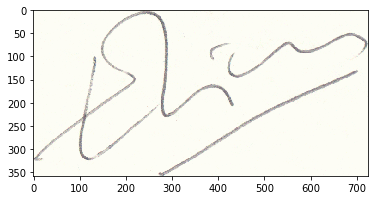

In [10]:
matplot.imshow(image)

In [11]:
image.shape

(359, 725, 3)

In [19]:
image = cv2.resize(image,(100,100))

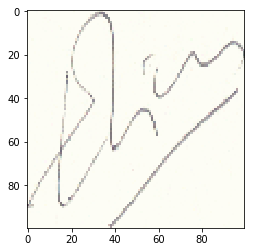

In [20]:
matplot.imshow(image)

In [21]:
cv2.imwrite("001_1_resized.png",image)

True